# Modify the planetary emission model by using realistic stellar spectrum (generated using pandexo's function) instead of assuming it to be a blackbody

In [76]:
# import area

import numpy as np
from astropy.modeling import models
from astropy import units as u
import math
import matplotlib.pyplot as plt
import matplotlib
#%matplotlib notebook
#for VSCode
%matplotlib inline
import time
#from numba import jit
#from pandexo.engine.bintools import binning
plt.rcParams['figure.dpi'] = 140
import pandexo.engine.justdoit as jdi # THIS IS THE HOLY GRAIL OF PANDEXO
import pandexo.engine.justplotit as jpi
import pandexo.engine.create_input as create
import pysynphot as psyn
from spectres import spectres 


### Test the pandexo function that generates a stellar spectrum and compare it to a blackbody

In [114]:
star_dict = {}
star_dict['type'] = 'phoenix'        #phoenix or user (if you have your own)
star_dict['mag'] = 10.046            #magnitude of the system (obtained from SIMBAD)
star_dict['ref_wave'] = 1.25         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
#star_dict['temp'] = 3036            #in K
star_dict['temp'] = 3500             # miniumum limit for pysynphot's ck04models grid
star_dict['metal'] = 0.0             # as log Fe/H (don't know this value)
#star_dict['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)
star_dict['logg'] = 5.00             # maximum limit for pysynphot's ck04models grid


In [122]:
# star_spec = create.outTrans(star_dict)

sp = psyn.Icat("phoenix", star_dict['temp'], star_dict['metal'], star_dict['logg'])
sp.convert("m")
sp.convert("jy")
stellar_wav_p = sp.wave
stellar_flux_p = sp.flux


sp = psyn.Icat("ck04models", star_dict['temp'], star_dict['metal'], star_dict['logg'])
sp.convert("m")
sp.convert("jy")
stellar_wav_c = sp.wave
stellar_flux_c = sp.flux



In [158]:
## also try the NextGen (solar) model that Nikole recommended

data = np.loadtxt('Resources/LHS3844_nextgensolar_spectrum.txt', skiprows=7)
stellar_wav_n = data[:,0]
stellar_flux_n = data[:,1]

# convert wavelength axis to m

stellar_wav_n = stellar_wav_n*10**-10

# convert from erg/cm2/s/A to jy (10^-23 ergs/cm2/s/Hz)

c = 3.0e+8
stellar_flux_n = 10**23*stellar_flux_n*10**10*(stellar_wav_n)**2/c

In [159]:
stellar_flux_n

array([2.937940249631999e-90, 6.035071831474665e-90,
       1.1000506814364663e-89, ..., 25228216282854.266,
       22509606520003.867, 20197155090003.6], dtype=object)

In [160]:
stellar_flux_c

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       1.63409046e+15, 1.20035041e+15, 9.17968389e+14])

### Run Hu et al. model for basalt with a pandexo stellar spectrum v/s a blackbody stellar spectrum

(1e-06, 2.4999999999999998e-05)

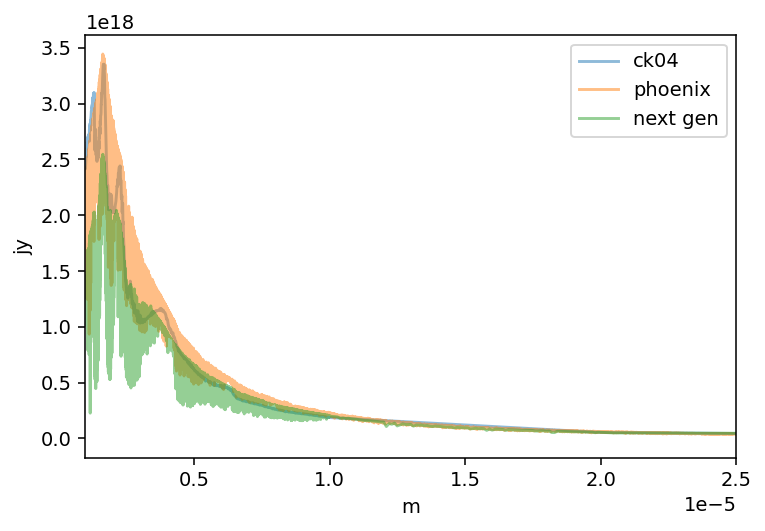

In [162]:
plt.figure()
#plt.plot(star_spec['wave'], star_spec['flux_out_trans'])
plt.plot(stellar_wav_c, stellar_flux_c, label='ck04', alpha=0.5)
plt.plot(stellar_wav_p, stellar_flux_p, label='phoenix', alpha=0.5)
plt.plot(stellar_wav_n, stellar_flux_n, label='next gen', alpha=0.5)
plt.xlabel('m')
plt.ylabel('jy')
plt.legend()
plt.xlim((1*10**-6,25*10**-6))
#plt.yscale('log')

**Ryan says ck04 grid is better, so let's use that**

In [166]:
### Convert everything to SI (wavelength in m and flux density in W m^-2 Hz^-1)

#slice the arrays between 1 and 25 microns

stellar_wav = stellar_wav_n
stellar_flux = stellar_flux_n

ind = np.where((stellar_wav > 1.0*10**-6) & (stellar_wav < 25.0*10**-6))
stellar_wav = stellar_wav[ind] # in meters

# the input flux density unit is Jy = 10^-26 W m^-2 Hz^-1
stellar_spec_grid = stellar_flux[ind]*10**-26  # in W m^-2 Hz^-1

# Now convert it to per unit wavelength

c = 3.0e+8
stellar_spec_grid = stellar_spec_grid*c/(stellar_wav)**2

### compare to black body flux

def bb(wav,T):
    pi = np.pi
    h = 6.626e-34
    c = 3.0e+8
    k = 1.38e-23

    
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity


stellar_spec_bb = bb(stellar_wav, star_dict['temp']) 

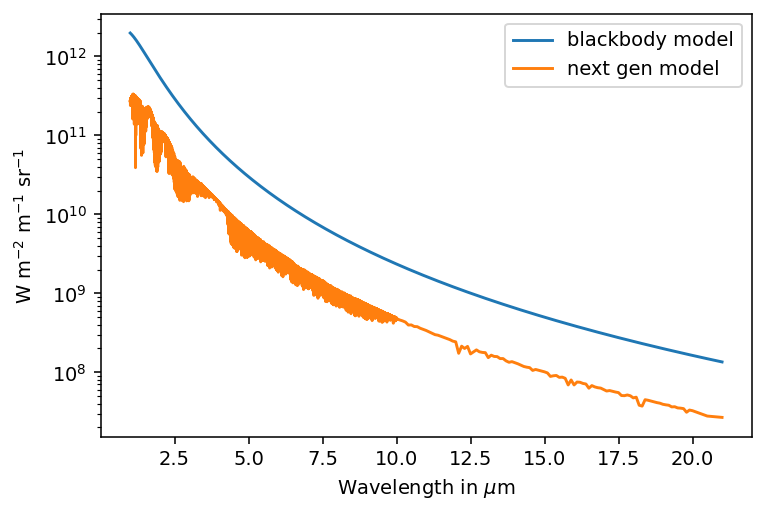

In [170]:
plt.figure()
plt.plot(stellar_wav*10**6, stellar_spec_bb, label='blackbody model')
# convert flux density to radiance
plt.plot(stellar_wav*10**6, stellar_spec_grid/(4*np.pi), label='next gen model')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('W m$^{-2}$ m$^{-1}$ sr$^{-1}$')
plt.legend()
#plt.xlim((5,25))
plt.yscale('log')

Text(0.5, 1.0, 'BB model / Nextgen model')

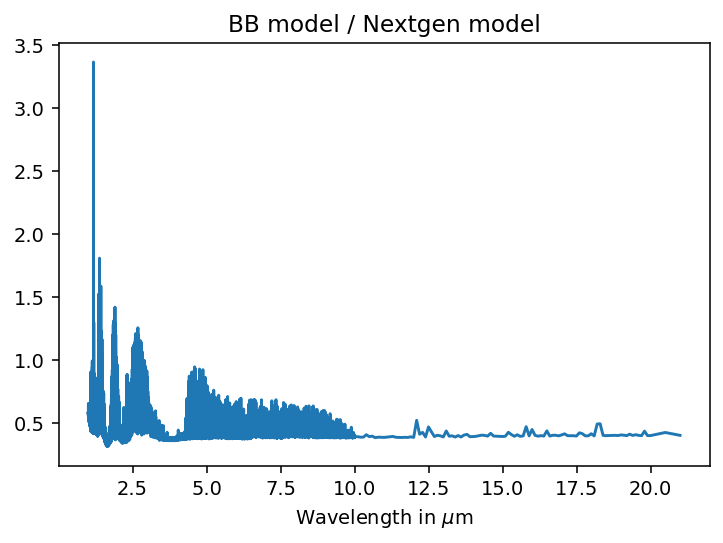

In [168]:
plt.figure()
plt.plot(stellar_wav*10**6, stellar_spec_bb/stellar_spec_grid)
plt.xlabel('Wavelength in $\mu$m')
#plt.ylabel('W m$^{-2}$ m$^{-1}$ sr$^{-1}$')
plt.title('BB model / Nextgen model')

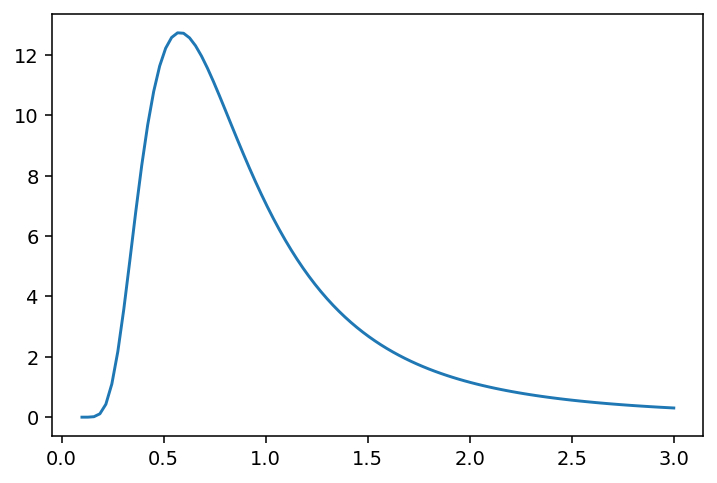

In [65]:
wav = np.linspace(0.1, 3, num=100) # microns
bb_spec = bb(wav*10**-6, 5000)

plt.figure()
plt.plot(wav, bb_spec*10**-9*10**-3)

In [66]:
bb_spec

array([3.67338446e+06, 6.94735691e+08, 1.53395006e+10, 1.11637757e+11,
       4.27975203e+11, 1.09997888e+12, 2.17158740e+12, 3.57488032e+12,
       5.17060093e+12, 6.80289948e+12, 8.33846936e+12, 9.68392610e+12,
       1.07871027e+13, 1.16299826e+13, 1.22190033e+13, 1.25759155e+13,
       1.27305018e+13, 1.27153851e+13, 1.25626603e+13, 1.23019293e+13,
       1.19593242e+13, 1.15571825e+13, 1.11141185e+13, 1.06453169e+13,
       1.01629289e+13, 9.67650041e+12, 9.19338759e+12, 8.71913788e+12,
       8.25782603e+12, 7.81234263e+12, 7.38463729e+12, 6.97592024e+12,
       6.58682768e+12, 6.21755600e+12, 5.86796976e+12, 5.53768786e+12,
       5.22615191e+12, 4.93267991e+12, 4.65650821e+12, 4.39682392e+12,
       4.15278982e+12, 3.92356309e+12, 3.70830937e+12, 3.50621304e+12,
       3.31648446e+12, 3.13836498e+12, 2.97113020e+12, 2.81409175e+12,
       2.66659814e+12, 2.52803480e+12, 2.39782349e+12, 2.27542135e+12,
       2.16031967e+12, 2.05204242e+12, 1.95014467e+12, 1.85421096e+12,
      